In [1]:
import numpy as np
from filterpy.kalman import EnsembleKalmanFilter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import time
from enkf import *
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from copy import deepcopy
import numpy as np
from numpy import dot, zeros, eye, outer
from numpy.random import multivariate_normal
from filterpy.common import pretty_str

In [2]:
class Lecture:

    def __init__(self, filename):
        
        self.tab_lorenz_x=[];
        self.tab_lorenz_y=[];
        self.tab_lorenz_z=[];
        self.tab_temps=[]
        f = open(filename, "r")
        line = f.readline().split()
        while line:
            self.tab_lorenz_x.append(float(line[1]))
            self.tab_lorenz_y.append(float(line[2]))
            self.tab_lorenz_z.append(float(line[3]))
            self.tab_temps.append(float(line[0]))
            line = f.readline().split()
            
        f.close()

class Lecture2:

    def __init__(self, filename):
        
        self.tab_lorenz=[];
        self.tab_temps=[]
        f = open(filename, "r")
        line = f.readline().split()
        while line:
            self.tab_lorenz.append([float(line[1]),float(line[2]),float(line[3])])
            self.tab_temps.append(float(line[0]))
            line = f.readline().split()
            
        f.close()

In [3]:
class EnsembleKalmanFilter2(object):
    def __init__(self, x, P, dim_z, dt, N, hx, fx):
        if dim_z <= 0:
            raise ValueError('dim_z must be greater than zero')

        if N <= 0:
            raise ValueError('N must be greater than zero')

        dim_x = len(x)
        self.dim_x = dim_x
        self.dim_z = dim_z
        self.dt = dt
        self.N = N
        self.hx = hx
        self.fx = fx
        self.K = np.zeros((dim_x, dim_z))
        self.z = np.array([[None]*self.dim_z]).T
        self.S = np.zeros((dim_z, dim_z))   # system uncertainty
        self.SI = np.zeros((dim_z, dim_z))  # inverse system uncertainty

        self.initialize(x, P)
        self.Q = eye(dim_x)       # process uncertainty
        self.R = eye(dim_z)       # state uncertainty
        self.inv = np.linalg.inv

        # used to create error terms centered at 0 mean for state and measurement
        self._mean = np.zeros(dim_x)
        self._mean_z = np.zeros(dim_z)

    def initialize(self, x, P):

        if x.ndim != 1:
            raise ValueError('x must be a 1D array')

        self.sigmas = multivariate_normal(mean=x, cov=P, size=self.N)
        self.x = x
        self.P = P

        # these will always be a copy of x,P after predict() is called
        self.x_prior = self.x.copy()
        self.P_prior = self.P.copy()

        # these will always be a copy of x,P after update() is called
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()


    def update(self, z, R=None):
        if z is None:
            self.z = np.array([[None]*self.dim_z]).T
            self.x_post = self.x.copy()
            self.P_post = self.P.copy()
            return

        if R is None:
            R = self.R
        if np.isscalar(R):
            R = eye(self.dim_z) * R

        N = self.N
        dim_z = len(z)
        sigmas_h = zeros((N, dim_z))

        # transform sigma points into measurement space
        for i in range(N):
            sigmas_h[i] = self.hx(self.sigmas[i])
        #print("sigma_h\n",sigmas_h)

        z_mean = np.mean(sigmas_h, axis=0)
        #print("z_mean\n",z_mean)

        P_zz = 0
        for sigma in sigmas_h:
            s = sigma - z_mean
            P_zz += outer(s, s)
        P_zz = P_zz / (N-1) + R
        self.S = P_zz
        #print("P_zz\n",P_zz)
        self.SI = self.inv(self.S)


        P_xz = 0
        for i in range(N):
            P_xz += outer(self.sigmas[i] - self.x, sigmas_h[i] - z_mean)
        P_xz /= N-1
        #print("P_xz\n",P_xz)

        self.K = dot(P_xz, self.inv(P_zz))
        #print("K\n",self.K)
        #print("mean_z\n",self._mean_z)

        e_r = multivariate_normal(self._mean_z, R, N)
        #print("e_r\n",e_r)
        for i in range(N):
            self.sigmas[i] += dot(self.K, z + e_r[i] - sigmas_h[i])
        #print("sigmas\n",self.sigmas)

        self.x = np.mean(self.sigmas, axis=0)
        #print("x\n",self.x)
        self.P = self.P - dot(dot(self.K, P_zz), self.K.T)
        #print("P\n",self.P)

        # save measurement and posterior state
        self.z = deepcopy(z)
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()
        #print("x_post\n",self.x_post)
        #print("P_post\n",self.P_post)


    def predict(self):
        N = self.N
        for i, s in enumerate(self.sigmas):
            self.sigmas[i] = self.fx(s, self.dt)
        e = multivariate_normal(self._mean, self.Q, N)
        
        self.sigmas += e

        P = 0
        for s in self.sigmas:
            sx = s - self.x
            P += outer(sx, sx)

        self.P = P / (N-1)
        # save prior
        self.x_prior = np.copy(self.x)
        self.P_prior = np.copy(self.P)
        #print(self.x_prior )
        #print(self.P_prior )


    def __repr__(self):
        return '\n'.join([
            'EnsembleKalmanFilter object',
            pretty_str('dim_x', self.dim_x),
            pretty_str('dim_z', self.dim_z),
            pretty_str('dt', self.dt),
            pretty_str('x', self.x),
            pretty_str('P', self.P),
            pretty_str('x_prior', self.x_prior),
            pretty_str('P_prior', self.P_prior),
            pretty_str('Q', self.Q),
            pretty_str('R', self.R),
            pretty_str('K', self.K),
            pretty_str('S', self.S),
            pretty_str('sigmas', self.sigmas),
            pretty_str('hx', self.hx),
            pretty_str('fx', self.fx)
            ])




In [4]:
def assimilation_donnée2(x,read_sensor,P,Q,R,T,dimz,dt,N,nb_echantillon,hx,fx,γ):
    f = EnsembleKalmanFilter2(x=x, P=P, dim_z=dimz, dt=dt, N=nb_echantillon,hx=hx, fx=lambda x,dt:fx(x,t,dt,γ))
    f.R = R # matrice de cov associer a la mesure
    f.Q =Q   #bruit blanc  centree en 0
    t=0
    index=N
    tab_etat=[]
    tab_temps=[]
    tab_cov=[]
    tab_etat.append(f.x)
    tab_temps.append(t)
    tab_cov.append(f.P_post.diagonal())
    while (t<(T-dt)):#
        z = read_sensor(index)
        f.predict()
        f.update(z)
        diag_cov=f.P_post.diagonal()
        tab_cov.append(diag_cov)
        index+=N
        t=t+dt
        tab_etat.append(f.x)
        tab_temps.append(t)
    return(np.array(tab_etat),np.array(tab_temps),np.array(tab_cov))





In [5]:
γ=(12.,6.,12.) #(σ,b,r)
X0=(-10.,-10.,25.) #(x0,y0,z0)
T=1
N=int(T/0.01)

In [6]:
lorenz1=RK4_Lorenz(γ,X0,N,T)

In [7]:
N=int(T/0.1)

In [8]:
lorenz2=RK4_Lorenz(γ,X0,N,T)
print(lorenz2)

(array([-10.        ,  -6.017     ,  -2.53725935,  -1.89851002,
        -2.44436736,  -3.91529905,  -6.51296524,  -9.75385504,
       -11.01920522,  -9.08568016,  -6.76900994]), array([-10.        ,  -1.78621533,  -1.14115502,  -1.90216439,
        -3.24768273,  -5.58910094,  -9.14577545, -12.15777719,
       -10.57519094,  -6.77958936,  -5.45855351]), array([25.        , 16.74395333,  9.54438723,  5.46595872,  3.41373458,
        2.95325982,  4.6318605 ,  9.48024805, 14.55820586, 14.38527267,
       11.30707921]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


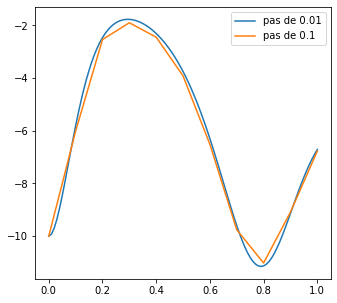

In [9]:
fig=plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(1,3,2)
ax1.plot(lorenz1[3],lorenz1[0],label="pas de 0.01")
ax1.plot(lorenz2[3],lorenz2[0],label="pas de 0.1")
ax1.legend()

In [10]:

γ=(12.,6.,12.)  #(σ,b,r)
N=10
T=1

x = np.array([-10.,-10.,25.])#(x0,y0,z0)
dt= N*0.01
P = np.eye(3) * 2.

[[-10.         -10.          25.        ]
 [ -5.80871707  -1.61510529  16.61029784]
 [ -2.46149896  -1.02674472   9.41887833]
 [ -1.77112079  -1.82018137   5.3726603 ]
 [ -2.31893496  -3.12603561   3.32733543]
 [ -3.75884195  -5.37544282   2.80058476]
 [ -6.30166403  -8.88830425   4.34542343]
 [ -9.60344952 -12.13150968   9.09337498]
 [-11.13342059 -10.79362125  14.54290963]
 [ -9.15277086  -6.74822522  14.56120057]
 [ -6.71133693  -5.32987441  11.32671425]]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


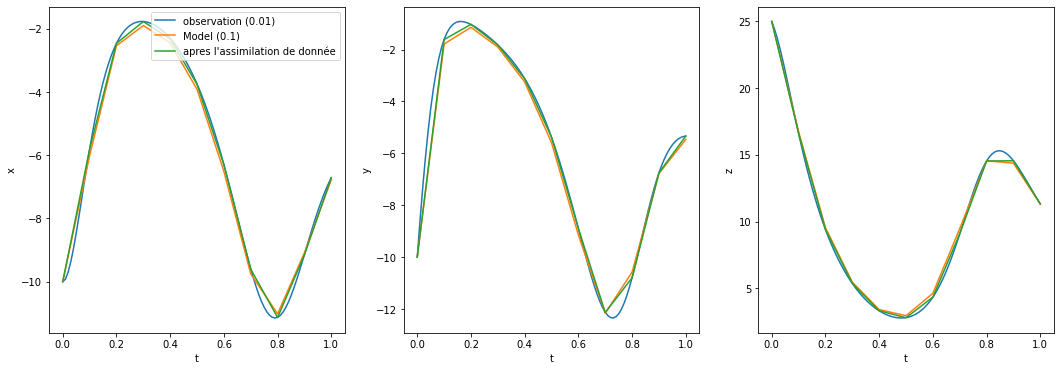

In [11]:
def hx_ex(x):
   return x

P=np.eye(3)*0.1
Q=np.eye(3)*0.1
R= np.eye(3)*0.001  
dt= N*0.01

def read_sensor_ex(index):
    return np.array([lorenz1[0][index],lorenz1[1][index],lorenz1[2][index]])

tab_model,tab_temps_model,tab_cov_model=assimilation_donnée2(x,read_sensor_ex,P,Q,R,T,3,dt,N,20,hx_ex,fx,γ)
print(tab_model)
print(tab_temps_model)
plot(lorenz1,lorenz2,tab_temps_model,tab_model)

In [15]:
Lorenz1=Lecture("plotlorenz1.csv")
Lorenz2=Lecture("plotlorenz2.csv")
Lorenz3=Lecture2("plotetat.csv")

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]


In [16]:
lorenz1=(np.array(Lorenz1.tab_lorenz_x),np.array(Lorenz1.tab_lorenz_y),np.array(Lorenz1.tab_lorenz_z),np.array(Lorenz1.tab_temps))
lorenz2=(np.array(Lorenz2.tab_lorenz_x),np.array(Lorenz2.tab_lorenz_y),np.array(Lorenz2.tab_lorenz_z),np.array(Lorenz2.tab_temps))
tab_etat=np.array(Lorenz3.tab_lorenz)
tab_temps=np.array(Lorenz3.tab_temps)


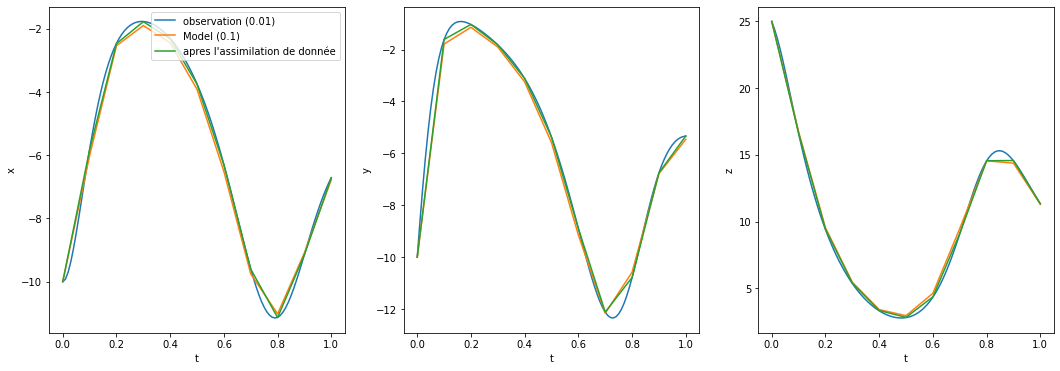

In [17]:
plot(lorenz1,lorenz2,tab_temps,tab_etat)